# Imports

In [324]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn import metrics
import bokeh.plotting as bp
import itertools
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tools.plotting import autocorrelation_plot
import datetime
from fbprophet import Prophet

# Reading in raw soil moisture data
At times, loading into Excel directly resulted in loss of negative signs. Loading into pandas first then saving the dataframe as an Excel file to be opened in Excel fixed this problem. See the file named `excel_cleaning` to read on how the data was cleaned in Excel.

In [2]:
# data = pd.read_clipboard(header=None)
# data.head()

In [3]:
# data.to_excel('soil_moisture_1988.xlsx')

# Creating the dataframes for soil moisture

In [4]:
# This function will add a zero to the beginning of a string if it is a certain length. 
# This allows the string to work with the next functions.
def add_zeros(string):
    if len(str(string)) == 7:
        return '0' + str(string)
    else:
        return str(string)

# This function will grab the four digit year from the values in the first column of the raw data.
def grab_four_digit_year(string):
    if len(str(string)) == 10:
        return str(string)[-6:-2]
    else:
        return str(string[-4:])
    
# This function will grab the two digit year from the values in the first column of the raw data.
def grab_two_digit_year(string):
    if len(str(string)) == 6:
        return '19' + str(string)[-2:]
    else:
        return '19' + str(string[-4:-2])
    
# This function will grab the state number from the values in the first column.
def grab_state(string):
    return str(string)[:2]

# This function will grab the division number from the values in the first column.
def grab_division(string):
    return str(string)[2:4]

### Actually pulling in the data.
This is done by using a for loop that will:
- loop through all the `soil_moisture` files
- bring in only certain predetermined columns as a dataframe
    - these columns are the id, week of the year, preipitation, average temperature, moisture in both soil layers, moisture anomly index, moisture in surface layer, moisture in underlying layer, palmer drought index, and crop moisture index.
- create new columns for each dataframe that will separate the year, state number, and division number into separate columns.
    - data before 1997 formatted the year differently so there is an `if` statement to account for this.
- filter out any data that isn't in Texas
- store that dataframe inside of a dictionary, with each key being `soil_moisture_year`

In [5]:
years_on_file = ['1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', 
                 '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008','2009', '2010', '2011', '2012', 
                 '2013', '2014', '2015', '2016', '2017']
years = {}
for year in years_on_file:
    df = pd.read_excel(f'/Users/MatthewZapata/Main_data_repo/moisture_data/soil_moisture_{year}.xlsx', header=None, 
                       usecols=[0, 1, 2, 3, 4, 21, 22, 23, 31, 34], 
                       dtype={0:'object', 1:'object'})
    df.columns = ['div_year', 'week', 'precip_total_inches', 'temp_average_F', 
                  'available_moisture_in_both_layers_start_in', 'moisture_anomaly_index', 
                  'available_moisture_surface_layer_in', 'available_moisture_underlying_layer_in',
                  'modified_palmer_drought_index', 'crop_moisture_index']
    
    df['div_year_with_zeros'] = df.div_year.apply(add_zeros)

    if int(year) >1996:
        df['year'] = df.div_year_with_zeros.apply(grab_four_digit_year)
    else:
        df['year'] = df.div_year_with_zeros.apply(grab_two_digit_year)

    df['state'] = df.div_year_with_zeros.apply(grab_state)

    df['division'] = df.div_year_with_zeros.apply(grab_division)
    
    
    df = df[df.state == '41']
    
    years[f'soil_moisture_{year}'] = df

##### Checking a couple of dictionaries, making sure it looks good.

In [6]:
years['soil_moisture_1997'].head()

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division
0,41011997,1,0.0,46,1.61,-0.36,0.84,0.61,1.75,0.01,41011997,1997,41,01
1,41011997,2,0.0,50,1.45,-0.45,0.58,0.61,1.36,0.02,41011997,1997,41,01
2,41011997,3,0.0,56,1.19,-0.58,0.18,0.61,0.88,0.02,41011997,1997,41,01
3,41011997,4,0.0,54,0.79,-0.58,0.00,0.59,0.41,-0.14,41011997,1997,41,01
4,41011997,5,1.7,53,0.59,2.51,1.00,0.95,2.21,0.29,41011997,1997,41,01


In [7]:
years['soil_moisture_1988'].head()

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division
0,410188,1,1.0,46,2.05,1.63,1.00,1.89,0,0.37,410188,1988,41,01
1,410188,2,0.0,48,2.89,-0.25,0.79,1.89,0,0.04,410188,1988,41,01
2,410188,3,0.3,35,2.68,0.46,1.00,1.97,0,0.17,410188,1988,41,01
3,410188,4,0.0,57,2.97,-0.23,0.56,1.97,0,0.11,410188,1988,41,01
4,410188,5,0.9,51,2.53,1.47,1.00,2.14,0,0.44,410188,1988,41,01


### The data needs dates.
In it's current state, there is only year and week of a (usually) 52 week period. Reading through the data sources documentation, the week counter starts on March 1. With this is mind, a for loop is used to group by year and division and give that group a column with dates.

##### Specifically, the for loop functions as follows:
- the first loop is looping through the different keys in the `years` dictionary.
- an empty list (`list_of_div`) is created within the first for loop. This list will contain the separate dataframes for each year and division. 
- the second loop is looping through the unique division numbers in each dictionary.
- a dataframe is made that contains only the data for the current division (determined by the loop).
- a date column is added to that dataframe, with all the dates being the same.
- the dates are changed to a datetime type.
- a for loop then goes through the date column and adds days to each value, increasing by 7 each time.
    - this makes it so that the first date is March 1st and increase by a week after that.
    - the results from the loop are put in a list and that list provides the values for a new column (`final_date`).
- each dataframe is added to a list which is then concatted after each division in a dictionary has been looped through.
- the values for the dictionaries are replaced with the joined list of dataframes.

In [8]:
for key in years:
    print(key)
    list_of_div = []
    for div_number in years[key].division.unique():
        df = years[key][years[key].division == div_number]
        df['date'] = f'{df.year.iloc[0]}-03-01'
        df['date'] = pd.to_datetime(df['date'])

        dates = []
        i=0
        for value in df.date:
            new_date = value + timedelta(days=i)
            dates.append(new_date)
            i += 7
    
        df['final_date'] = dates
        list_of_div.append(df)
    joined_df = pd.concat(list_of_div)
        
    years[key] = joined_df

soil_moisture_1988


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

soil_moisture_1989
soil_moisture_1990
soil_moisture_1991
soil_moisture_1992
soil_moisture_1993
soil_moisture_1994
soil_moisture_1995
soil_moisture_1996
soil_moisture_1997
soil_moisture_1998
soil_moisture_1999
soil_moisture_2000
soil_moisture_2001
soil_moisture_2002
soil_moisture_2003
soil_moisture_2004
soil_moisture_2005
soil_moisture_2006
soil_moisture_2007
soil_moisture_2008
soil_moisture_2009
soil_moisture_2010
soil_moisture_2011
soil_moisture_2012
soil_moisture_2013
soil_moisture_2014
soil_moisture_2015
soil_moisture_2016
soil_moisture_2017


##### Checking dictionaries again.

In [9]:
years['soil_moisture_2017'].head()

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
0,41012017,1,0.00,47.8,1.66,-0.40,0.48,0.98,1.00,0.02,41012017,2017,41,01,2017-03-01,2017-03-01
1,41012017,2,0.01,55.3,1.46,-0.61,0.11,0.98,0.50,0.02,41012017,2017,41,01,2017-03-01,2017-03-08
2,41012017,3,0.00,56.2,1.09,-0.79,0.00,0.93,-0.12,-0.32,41012017,2017,41,01,2017-03-01,2017-03-15
3,41012017,4,0.11,63.2,0.93,-0.93,0.00,0.85,-0.82,-0.91,41012017,2017,41,01,2017-03-01,2017-03-22
4,41012017,5,1.35,53.6,0.85,1.86,1.00,0.85,0.53,-0.28,41012017,2017,41,01,2017-03-01,2017-03-29


In [10]:
years['soil_moisture_1990'].head()

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
0,410190,1,0.4,54,2.08,0.28,1.00,1.14,0,0.05,410190,1990,41,01,1990-03-01,1990-03-01
1,410190,2,0.3,51,2.14,0.16,1.00,1.16,0,0.04,410190,1990,41,01,1990-03-01,1990-03-08
2,410190,3,0.0,51,2.16,-0.40,0.72,1.16,0,0.04,410190,1990,41,01,1990-03-01,1990-03-15
3,410190,4,0.5,41,1.88,0.75,1.00,1.30,0,0.18,410190,1990,41,01,1990-03-01,1990-03-22
4,410190,5,0.1,53,2.30,-0.12,0.76,1.30,0,0.07,410190,1990,41,01,1990-03-01,1990-03-29


### Joining all of the dictionaries
Index is reset since dictionary keys were part of the index.

In [11]:
soil = pd.concat(years).reset_index()
soil.head()

,level_0,level_1,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
0,soil_moisture_1988,0,410188,1,1.0,46.0,2.05,1.63,1.00,1.89,0.0,0.37,410188,1988,41,01,1988-03-01,1988-03-01
1,soil_moisture_1988,1,410188,2,0.0,48.0,2.89,-0.25,0.79,1.89,0.0,0.04,410188,1988,41,01,1988-03-01,1988-03-08
2,soil_moisture_1988,2,410188,3,0.3,35.0,2.68,0.46,1.00,1.97,0.0,0.17,410188,1988,41,01,1988-03-01,1988-03-15
3,soil_moisture_1988,3,410188,4,0.0,57.0,2.97,-0.23,0.56,1.97,0.0,0.11,410188,1988,41,01,1988-03-01,1988-03-22
4,soil_moisture_1988,4,410188,5,0.9,51.0,2.53,1.47,1.00,2.14,0.0,0.44,410188,1988,41,01,1988-03-01,1988-03-29


##### Making sure all years are accounted for and what is expected.

In [12]:
soil.year.unique()

array(['1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'], dtype=object)

##### There should only be one state at this point.
41 is the state number for Texas.

In [13]:
soil.state.unique()

array(['41'], dtype=object)

##### There should be 10 divisions.

In [14]:
soil.division.unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

##### Setting week number as an `int` type, otherwise there are string values as well.

In [15]:
soil.week = soil.week.astype('int')
soil.week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])

### Cleaning up the dataframe by getting rid of unneeded columns.

In [16]:
soil.columns

Index(['level_0', 'level_1', 'div_year', 'week', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in',
       'modified_palmer_drought_index', 'crop_moisture_index',
       'div_year_with_zeros', 'year', 'state', 'division', 'date',
       'final_date'],
      dtype='object')

In [17]:
soil = soil[['state', 'division', 'year', 'week', 'date', 'final_date', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in', 'modified_palmer_drought_index',
       'crop_moisture_index']]

##### Checking to make sure the columns related to soil moisture make sense.
Moisture in both layers should be close to the summation.

In [18]:
(soil[['available_moisture_in_both_layers_start_in', 'available_moisture_surface_layer_in', 
      'available_moisture_underlying_layer_in']]
 .assign(summation=(soil.available_moisture_surface_layer_in + soil.available_moisture_underlying_layer_in))
 .sample(10))

,available_moisture_in_both_layers_start_in,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,summation
10835,4.43,0.00,4.37,4.37
6262,0.31,0.00,0.27,0.27
168,4.51,0.00,4.10,4.10
2239,7.00,1.00,6.00,7.00
10186,4.98,0.61,4.00,4.61
4667,0.21,0.00,0.16,0.16
6655,0.89,0.00,0.68,0.68
9855,1.05,0.17,0.73,0.90
6961,7.00,0.15,6.00,6.15
3726,6.12,0.00,4.73,4.73


##### Adding labels for the divisions.
These labels were determined from the file called `division_names`.

In [19]:
division_table = pd.DataFrame({'id':['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
              'division_name':['high_plains', 'low_rolling_plains', 'north_central', 'east_texas', 'trans_pecos', 
                              'edwards_plateau', 'south_central', 'upper_coast', 'southern', 'lower_valley']})

In [20]:
labeled_soil = soil.merge(division_table, left_on='division', right_on='id')
labeled_soil.head()

,state,division,year,week,date,final_date,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,id,division_name
0,41,01,1988,1,1988-03-01,1988-03-01,1.0,46.0,2.05,1.63,1.00,1.89,0.0,0.37,01,high_plains
1,41,01,1988,2,1988-03-01,1988-03-08,0.0,48.0,2.89,-0.25,0.79,1.89,0.0,0.04,01,high_plains
2,41,01,1988,3,1988-03-01,1988-03-15,0.3,35.0,2.68,0.46,1.00,1.97,0.0,0.17,01,high_plains
3,41,01,1988,4,1988-03-01,1988-03-22,0.0,57.0,2.97,-0.23,0.56,1.97,0.0,0.11,01,high_plains
4,41,01,1988,5,1988-03-01,1988-03-29,0.9,51.0,2.53,1.47,1.00,2.14,0.0,0.44,01,high_plains


### Reordering the columns and only keeping what's needed.

In [21]:
labeled_soil.columns

Index(['state', 'division', 'year', 'week', 'date', 'final_date',
       'precip_total_inches', 'temp_average_F',
       'available_moisture_in_both_layers_start_in', 'moisture_anomaly_index',
       'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in',
       'modified_palmer_drought_index', 'crop_moisture_index', 'id',
       'division_name'],
      dtype='object')

In [22]:
labeled_soil = labeled_soil[['final_date', 'division_name', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in', 'modified_palmer_drought_index',
       'crop_moisture_index']]

##### Checking that the labels make sense.

In [23]:
labeled_soil[labeled_soil.division_name == 'southern'].head()

,final_date,division_name,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index
12568,1988-03-01,southern,0.1,68.0,0.17,-0.55,0.0,0.15,0.0,-0.49
12569,1988-03-08,southern,0.0,68.0,0.15,-0.66,0.0,0.14,0.0,-1.17
12570,1988-03-15,southern,0.5,56.0,0.14,0.59,0.3,0.14,0.0,-0.60
12571,1988-03-22,southern,0.0,71.0,0.44,-0.34,0.0,0.13,0.0,-0.68
12572,1988-03-29,southern,0.0,72.0,0.13,-0.64,0.0,0.12,0.0,-1.48


### Looking at the division names.
It is determined that the division we want is `south central` since that region is where San Antonio is located. A new dataframe is created with only the data that comes from the south central region.

In [24]:
labeled_soil.division_name.unique()

array(['high_plains', 'low_rolling_plains', 'north_central', 'east_texas',
       'trans_pecos', 'edwards_plateau', 'south_central', 'upper_coast',
       'southern', 'lower_valley'], dtype=object)

In [68]:
south_central_moisture = labeled_soil[labeled_soil.division_name == 'south_central']

In [69]:
south_central_moisture = south_central_moisture[['final_date', 'available_moisture_in_both_layers_start_in', 'modified_palmer_drought_index']]
south_central_moisture.columns = ['final_date', 'soil_moisture', 'pdsi']
south_central_moisture.head()

,final_date,soil_moisture,pdsi
9426,1988-03-01,4.79,0.0
9427,1988-03-08,4.67,0.0
9428,1988-03-15,4.24,0.0
9429,1988-03-22,5.59,0.0
9430,1988-03-29,5.00,0.0


### Performing a describe to make sure everything looks right.

In [70]:
south_central_moisture.describe(include='all')

,final_date,soil_moisture,pdsi
count,1571,1571.000000,1571.000000
unique,1571,NaN,NaN
top,2015-07-19 00:00:00,NaN,NaN
freq,1,NaN,NaN
first,1988-03-01 00:00:00,NaN,NaN
last,2018-02-28 00:00:00,NaN,NaN
mean,NaN,3.767626,0.211464
std,NaN,2.746537,2.548841
min,NaN,0.010000,-5.820000
25%,NaN,1.220000,-1.715000


##### Reading the south central dataframe to a csv file.

In [71]:
# south_central_moisture.to_csv('south_central_moisture_data_1988_2017.csv', index=False)

# Modeling
### First we need to aggregate the data, which will be done by months.

In [72]:
df = pd.read_csv('south_central_moisture_data_1988_2017.csv')
df.head()

,final_date,soil_moisture,pdsi
0,1988-03-01,4.79,0.0
1,1988-03-08,4.67,0.0
2,1988-03-15,4.24,0.0
3,1988-03-22,5.59,0.0
4,1988-03-29,5.00,0.0


In [73]:
df.dtypes

final_date        object
soil_moisture    float64
pdsi             float64
dtype: object

##### Making the date an actual datetime type.

In [74]:
df.final_date = pd.to_datetime(df.final_date)

##### Setting the index to be the date so that we can resample the data

In [75]:
df = df.set_index('final_date')
df.head()

,soil_moisture,pdsi
final_date,,
1988-03-01,4.79,0.0
1988-03-08,4.67,0.0
1988-03-15,4.24,0.0
1988-03-22,5.59,0.0
1988-03-29,5.00,0.0


### Back to resampling

In [76]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
print(f'Range of index: {df.index[0], df.index[-1]}')

Number of rows: 1571
Number of columns: 2
Range of index: (Timestamp('1988-03-01 00:00:00'), Timestamp('2018-02-28 00:00:00'))


Note to self: At this point I am aggregating by month, but I may want to consider aggregating by week to see if that is any better.

In [77]:
df_agg = df.soil_moisture.resample('M').agg('mean')

In [78]:
df_agg.head()

final_date
1988-03-31    4.8580
1988-04-30    4.3975
1988-05-31    3.6040
1988-06-30    2.8650
1988-07-31    1.4750
Freq: M, Name: soil_moisture, dtype: float64

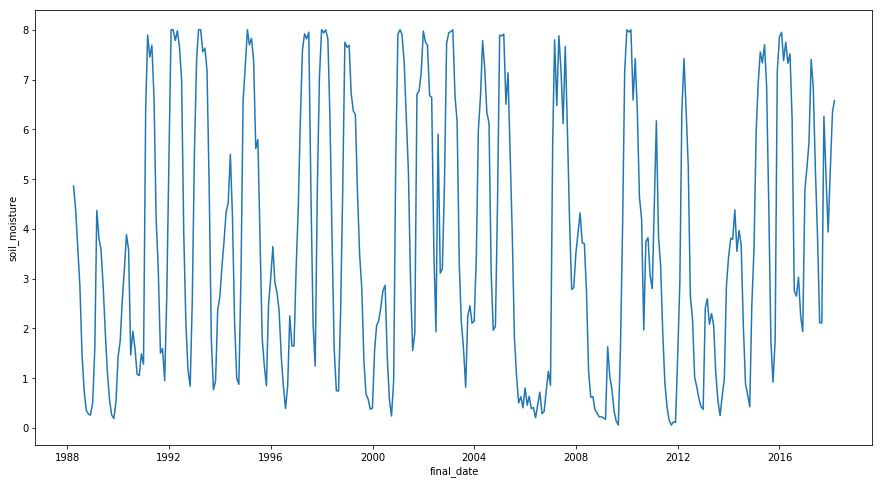

In [79]:
plt.figure(figsize=(15, 8))
sns.lineplot(df_agg.reset_index().final_date, df_agg.reset_index().soil_moisture)

##### Looking at the range of dates, considering the number of rows, and considering that we will want to cross validate to tune the hyperparameters, a good split would be putting 66% of the data to train and 33% to test. The 66% of the data going to train will be split in half to from the train and validation set.

In [80]:
split_point_test = round(df_agg.shape[0] * .66)
print(f'For the test set, we will want to split at this index: {split_point_test}')

split_point_train_validate = round(split_point_test/2)
print(f'For the train and validate set, we will want to split at this index: {split_point_train_validate}')

For the test set, we will want to split at this index: 238
For the train and validate set, we will want to split at this index: 119


##### The actual splitting of the data

In [81]:
train = np.array(df_agg[:split_point_train_validate])
validate = np.array(df_agg[split_point_train_validate:split_point_test])
test = np.array(df_agg[split_point_test:])

In [82]:
print(f'Number of years in train: {round(train.shape[0]/12)}')
print(f'Number of years in validate: {round(validate.shape[0]/12)}')
print(f'Number of years in test: {round(test.shape[0]/12)}')

Number of years in train: 10
Number of years in validate: 10
Number of years in test: 10


In [83]:
print(f'Number of rows in train set: {train.shape[0]}')
print(f'Number of rows in validate set: {validate.shape[0]}')
print(f'Number of rows in test set: {test.shape[0]}')

Number of rows in train set: 119
Number of rows in validate set: 119
Number of rows in test set: 122


##### Splitting the current training set in half to have a validation set.

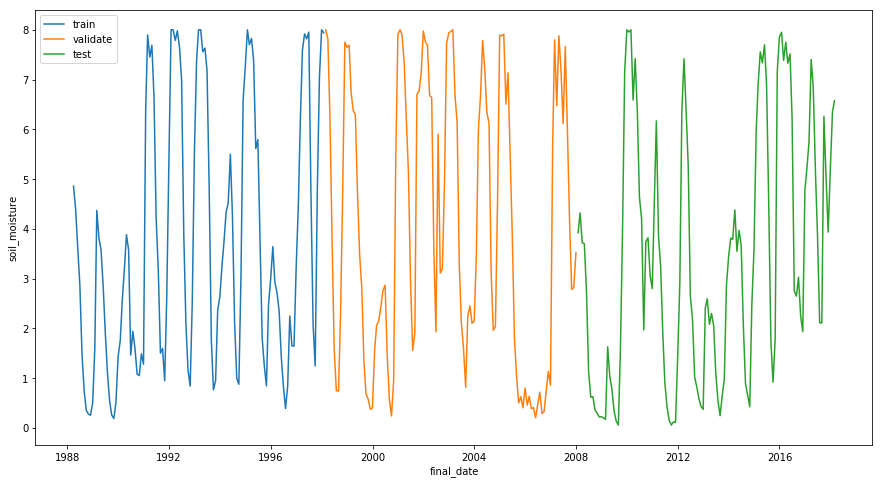

In [84]:
plt.figure(figsize=(15, 8))
sns.lineplot(df_agg.reset_index().final_date,
             df_agg.reset_index().soil_moisture[:split_point_train_validate],
             label='train')
sns.lineplot(df_agg.reset_index().final_date,
             df_agg.reset_index().soil_moisture[split_point_train_validate:split_point_test],
             label='validate')
sns.lineplot(df_agg.reset_index().final_date,
             df_agg.reset_index().soil_moisture[split_point_test:],
             label='test')
plt.show()

### This function allows us to create the SVR model. 
It will take in an array, window size, and step length. It then returns two arrays, one for x values and one for y values. 

In [85]:
def embed_data(x, window_size, steps_away):
    n = len(x)
    # steps = n - steps_away
    # print(f'n: {n}')
    xout = np.zeros((n-window_size-steps_away, window_size))
    # print(f'xout: {xout}')
    # print(f'shape of xout: {xout.shape}')
    yout = x[(window_size + steps_away):]
    # print(f'yout: {yout}')
    # print(f'shape of yout: {yout.shape}')
    if steps_away == 0:
        for i in np.arange(window_size, n):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout
    else:
        for i in np.arange(window_size, n-steps_away-window_size):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout

In [86]:
window_size = 6
steps_away = 0

xtrain, ytrain = embed_data(train, window_size, steps_away)
xvalidate, yvalidate = embed_data(validate, window_size, steps_away)
xtest, ytest = embed_data(test, window_size, steps_away)

In [87]:
print(xtrain[0:5])
print(ytrain[0:5])

[[4.858  4.3975 3.604  2.865  1.475  0.738 ]
 [4.3975 3.604  2.865  1.475  0.738  0.3525]
 [3.604  2.865  1.475  0.738  0.3525 0.275 ]
 [2.865  1.475  0.738  0.3525 0.275  0.254 ]
 [1.475  0.738  0.3525 0.275  0.254  0.5025]]
[0.3525 0.275  0.254  0.5025 1.61  ]


Checking to make sure the function did what we wanted it to and didn't leave any nulls.

In [88]:
pd.DataFrame(xtrain).assign(y_value=ytrain).head()

,0,1,2,3,4,5,y_value
0,4.8580,4.3975,3.6040,2.8650,1.4750,0.7380,0.3525
1,4.3975,3.6040,2.8650,1.4750,0.7380,0.3525,0.2750
2,3.6040,2.8650,1.4750,0.7380,0.3525,0.2750,0.2540
3,2.8650,1.4750,0.7380,0.3525,0.2750,0.2540,0.5025
4,1.4750,0.7380,0.3525,0.2750,0.2540,0.5025,1.6100


In [89]:
pd.DataFrame(xtrain).assign(y_value=ytrain).tail()

,0,1,2,3,4,5,y_value
108,7.5880,7.9175,7.8180,7.9525,4.7300,2.0760,1.2425
109,7.9175,7.8180,7.9525,4.7300,2.0760,1.2425,4.7975
110,7.8180,7.9525,4.7300,2.0760,1.2425,4.7975,7.0460
111,7.9525,4.7300,2.0760,1.2425,4.7975,7.0460,8.0000
112,4.7300,2.0760,1.2425,4.7975,7.0460,8.0000,7.9380


### SVR model
Fitting the model on the train set.

In [90]:
m = svm.SVR(kernel='rbf', gamma='auto_deprecated', C=1.0)
# C is our regularization constant
m_fit = m.fit(xtrain, ytrain)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Making predictions on the train set.

In [91]:
y_pred = m_fit.predict(xtrain)

Evaluating the model.

In [92]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, ytrain)
print(mse)

0.9639530909903573


Plotting the predictions against the actual values.

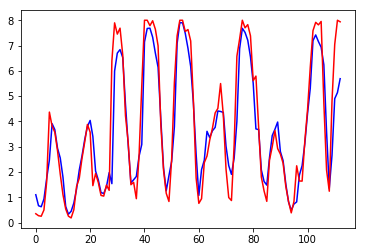

In [93]:
plt.plot(y_pred, 'b-', ytrain, 'r-')

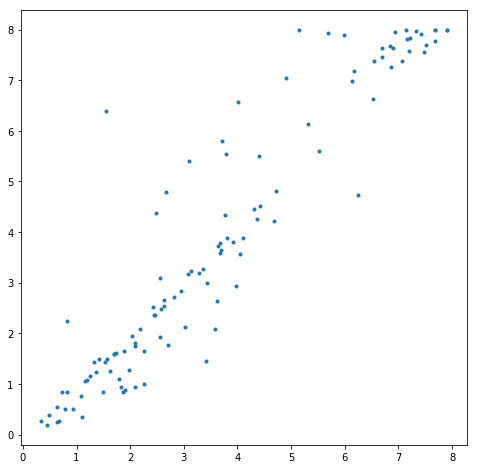

In [94]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, ytrain, '.')
plt.show()

Predicting on the validate set.

In [95]:
y_pred = m_fit.predict(xvalidate)

Evaluating the predictions.

In [96]:
mse = metrics.mean_squared_error(y_pred, yvalidate)
print(mse)

2.7487779308852334


Plotting again.

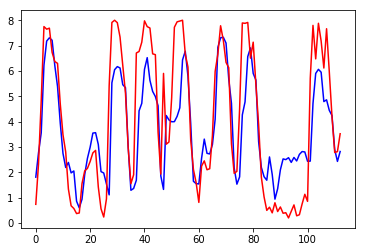

In [97]:
plt.plot(y_pred, 'b-', yvalidate, 'r-')

In [98]:
print(f'Accuracy: {m_fit.score(xvalidate,yvalidate)}')
print(f'R2: {metrics.r2_score(yvalidate,y_pred)}')

Accuracy: 0.6402450083480462
R2: 0.6402450083480462


### This is just plotting the same values but adds years to the x-axis.

In [99]:
date_and_preds = pd.DataFrame([df_agg.index[split_point_train_validate+window_size+steps_away:split_point_test], yvalidate, y_pred]).T
date_and_preds.columns = ['date', 'yvalidate', 'ypred']
date_and_preds.head()

,date,yvalidate,ypred
0,1998-08-31 00:00:00,0.738,1.80977
1,1998-09-30 00:00:00,2.3275,2.76941
2,1998-10-31 00:00:00,4.83,3.55788
3,1998-11-30 00:00:00,7.75,6.22824
4,1998-12-31 00:00:00,7.6475,7.1777


In [100]:
date_and_preds.tail()

,date,yvalidate,ypred
108,2007-08-31 00:00:00,5.974,4.4452
109,2007-09-30 00:00:00,4.1875,4.24025
110,2007-10-31 00:00:00,2.7825,2.89632
111,2007-11-30 00:00:00,2.818,2.43132
112,2007-12-31 00:00:00,3.5225,2.82142


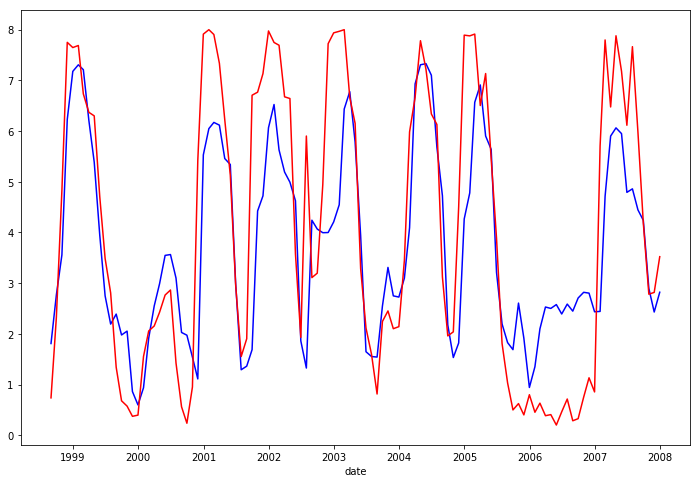

In [101]:
plt.figure(figsize=(12, 8))
sns.lineplot(date_and_preds.date, y_pred, color='blue')
sns.lineplot(date_and_preds.date, yvalidate, color='red')
plt.show()

# Looping through different values for window size, steps, C weight, and gamma to determine the combination that gives the lowest MSE and highest r squared.

In [102]:
windows_to_try = [3, 6, 9, 12, 18, 24]
steps_to_try = [2, 6, 9, 12]
c_to_try = [2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15]
gamma_to_try = [2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15]

average_mse_dict = {}
validate_mse_dict = {}
average_r2 = {}
validate_r2 = {}
for combo in list(itertools.product(windows_to_try, steps_to_try)):
    # print(f'Window size: {combo[0]}     Step size: {combo[1]}')
    xtrain, ytrain = embed_data(train, combo[0], combo[1])
    xvalidate, yvalidate = embed_data(validate, combo[0], combo[1])
    for cg_combo in list(itertools.product(c_to_try, gamma_to_try)):
        # print(f'C: {cg_combo[0]}     Gamma: {cg_combo[1]}')
        m = svm.SVR(kernel='rbf', C=cg_combo[0], gamma=cg_combo[1])
        # C is our regularization constant
        m_fit = m.fit(xtrain, ytrain)
        # print('Train')
        y_pred_train = m_fit.predict(xtrain)
        # mean squared error
        mse_train = metrics.mean_squared_error(y_pred_train, ytrain)
        accuracy_train = m_fit.score(xtrain,ytrain)
        # plt.plot(y_pred, 'b-', ytrain, 'r-')
        # plt.show()
        # print('Validate')
        y_pred_validate = m_fit.predict(xvalidate)
        # mean squared error
        mse_validate = metrics.mean_squared_error(y_pred_validate, yvalidate)
        accuracy_validate = m_fit.score(xvalidate,yvalidate)
        average_mse_dict[f'window: {combo[0]}  step: {combo[1]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = ((mse_train + mse_validate)/2)
        validate_mse_dict[f'window: {combo[0]}  step: {combo[1]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = mse_validate
        average_r2[f'window: {combo[0]}  step: {combo[1]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = ((accuracy_train + accuracy_validate)/2)
        validate_r2[f'window: {combo[0]}  step: {combo[1]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = accuracy_validate
        # plt.plot(y_pred, 'b-', ytrain, 'r-')
        # plt.show()
    
print(f'The best window-step/hyperparameter combination by average MSE was: {min(average_mse_dict, key=average_mse_dict.get)}')
print(f"The average MSE for that combo was: {average_mse_dict[f'{min(average_mse_dict, key=average_mse_dict.get)}']}")
print('\n')
print(f'The best window-step/hyperparameter combination by just the validation MSE was: {min(validate_mse_dict, key=validate_mse_dict.get)}')
print(f"The MSE for the validate set for that combo was: {validate_mse_dict[f'{min(validate_mse_dict, key=validate_mse_dict.get)}']}")
print('\n')
print(f'The best window-step/hyperparameter combination by just the validation R2 was: {max(validate_r2, key=validate_r2.get)}')
print(f"The R2 for the validate set for that combo was: {validate_r2[f'{max(validate_r2, key=validate_r2.get)}']}")
print('\n')
print(f'The best window-step/hyperparameter combination by average R2 was: {max(average_r2, key=average_r2.get)}')
print(f"The average R2 for the validate set for that combo was: {average_r2[f'{max(average_r2, key=average_r2.get)}']}")

The best window-step/hyperparameter combination by average MSE was: window: 6  step: 6  c:4096  gamma: 1
The average MSE for that combo was: 3.9184074327013247


The best window-step/hyperparameter combination by just the validation MSE was: window: 6  step: 2  c:32  gamma: 0.0009765625
The MSE for the validate set for that combo was: 5.569129574353098


The best window-step/hyperparameter combination by just the validation R2 was: window: 6  step: 2  c:32  gamma: 0.0009765625
The R2 for the validate set for that combo was: 0.27197157508857717


The best window-step/hyperparameter combination by average R2 was: window: 6  step: 2  c:4096  gamma: 1
The average R2 for the validate set for that combo was: 0.4791991378630049


##### It seems that the best combination of window size and step size is window: 3, step: 2. The best hyperparameters were a C of 1 and a gamma of 0.3
This means that the Support Vector Regressor will be looking at a window of the 6 most recent months, not to include the 2 most recent months, to determine what the soil moisture will be for the next month. Unfortunately, this would mean that any sort of drought warning would only appear 2 months ahead of time, not leaving much time to prepare. This will have to be taken into consideration, perhaps accepting a higher MSE for the sake of an earlier warning.

Train MSE: 4.575315854345952


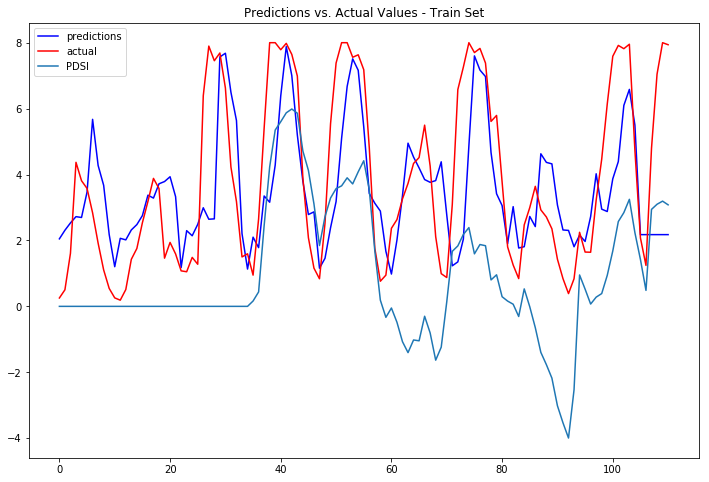

Validate MSE: 5.569129574353098


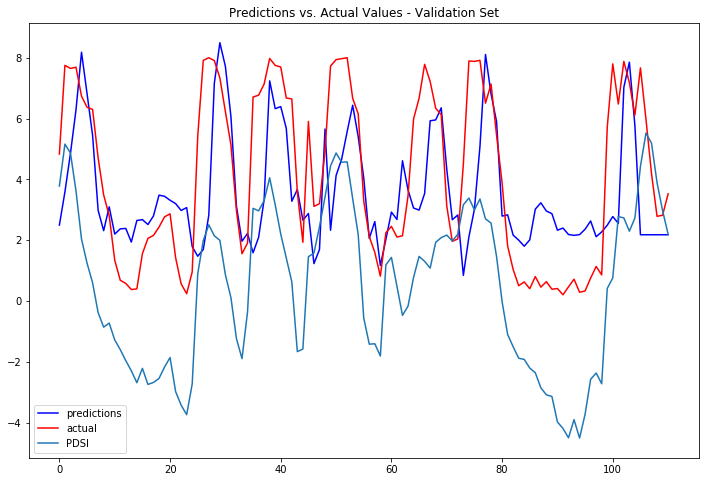

Test MSE: 4.865031773376458


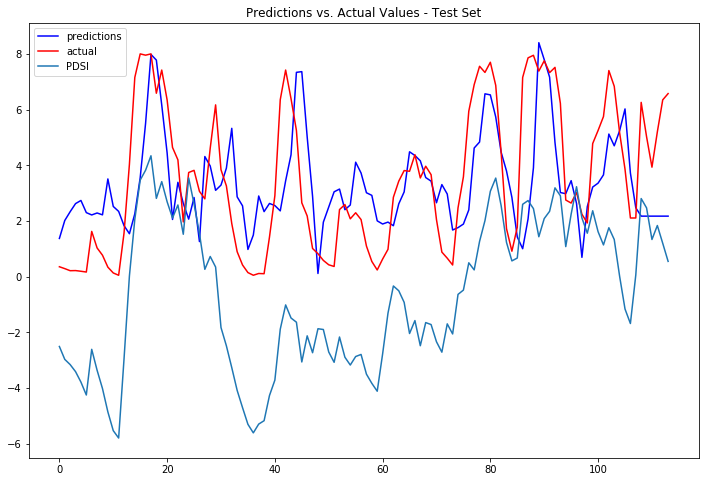

In [104]:
window_size = 6
steps_away = 2
C = 32
gamma = 0.0009765625


xtrain, ytrain = embed_data(train, window_size, steps_away)
xvalidate, yvalidate = embed_data(validate, window_size, steps_away)
xtest, ytest = embed_data(test, window_size, steps_away)
m = svm.SVR(kernel='rbf', C=C, gamma=gamma)
# C is our regularization constant
m_fit = m.fit(xtrain, ytrain)
y_pred = m_fit.predict(xtrain)
# mean squared error
mse = metrics.mean_squared_error(y_pred, ytrain)
print(f'Train MSE: {mse}')
plt.figure(figsize=(12,8))
plt.plot(y_pred, 'b-', ytrain, 'r-', 
        (np.array(df.pdsi.resample('M')
                   .agg('mean')[window_size+steps_away:split_point_train_validate])))
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Train Set')
plt.show()

y_pred_validate = m_fit.predict(xvalidate)
mse_validate = metrics.mean_squared_error(y_pred_validate, yvalidate)
print(f'Validate MSE: {mse_validate}')
plt.figure(figsize=(12,8))
plt.plot(y_pred_validate, 'b-', yvalidate, 'r-',
         (np.array(df.pdsi.resample('M')
                   .agg('mean')[split_point_train_validate+window_size+steps_away:split_point_test])))
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Validation Set')
plt.show()

y_pred_test = m_fit.predict(xtest)
mse_test = metrics.mean_squared_error(y_pred_test, ytest)
print(f'Test MSE: {mse_test}')
plt.figure(figsize=(12,8))
plt.plot(y_pred_test, 'b-', ytest, 'r-', 
         (np.array(df.pdsi.resample('M')
                   .agg('mean')[split_point_test+window_size+steps_away:])))
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Test Set')
plt.show()

### Using GridSearchCV to determine best hyperparameters

In [105]:
m = svm.SVR()
parameters = {'kernel':['rbf'], 'gamma':[2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15], 
             'C':[2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15]}
# cv = 
g = GridSearchCV(svm.SVR(), parameters )
g.fit(xtrain, ytrain)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': [3.0517578125e-05, 0.0009765625, 0.03125, 1, 32, 1024, 4096, 32768], 'C': [3.0517578125e-05, 0.0009765625, 0.03125, 1, 32, 1024, 4096, 32768]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
g.best_params_

{'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}

### Trying out ARIMA

In [107]:
# fitting model

series = df_agg[:split_point_train_validate]

# order parameters = (p, d, q)
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced
# q = size of the moving average window

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

                             ARIMA Model Results                              
Dep. Variable:        D.soil_moisture   No. Observations:                  118
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -181.104
Method:                       css-mle   S.D. of innovations              1.119
Date:                Tue, 04 Jun 2019   AIC                            376.209
Time:                        15:50:35   BIC                            395.604
Sample:                    04-30-1988   HQIC                           384.084
                         - 01-31-1998                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0177      0.107      0.166      0.868      -0.191       0.227
ar.L1.D.soil_moisture     0.4719      0.091      5.206      0.000       0.294       0.650
ar.L2.D.

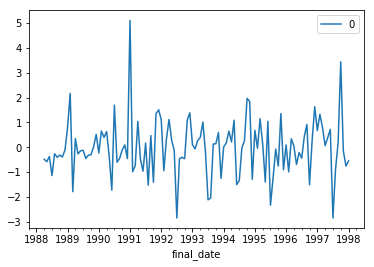

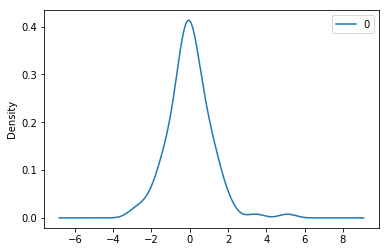

                0
count  118.000000
mean    -0.008838
std      1.124900
min     -2.840889
25%     -0.531455
50%     -0.050936
75%      0.576473
max      5.106427


In [108]:
# plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=7.325539, expected=8.000000
predicted=7.137431, expected=7.820000
predicted=7.313624, expected=6.237500
predicted=5.367482, expected=3.752000
predicted=2.708152, expected=1.582500
predicted=0.856307, expected=0.747500
predicted=0.921346, expected=0.738000
predicted=1.502511, expected=2.327500
predicted=3.849457, expected=4.830000
predicted=6.435725, expected=7.750000
predicted=9.065238, expected=7.647500
predicted=6.931334, expected=7.688000
predicted=6.885733, expected=6.733333
predicted=5.506452, expected=6.370000
predicted=5.749315, expected=6.300000
predicted=6.430734, expected=4.706000
predicted=4.063282, expected=3.487500
predicted=3.217362, expected=2.807500
predicted=2.785903, expected=1.342000
predicted=0.940445, expected=0.680000
predicted=0.896492, expected=0.575000
predicted=0.956295, expected=0.374000
predicted=0.588127, expected=0.397500
predicted=0.718817, expected=1.554000
predicted=2.261454, expected=2.056667
predicted=2.249665, expected=2.156000
predicted=2.

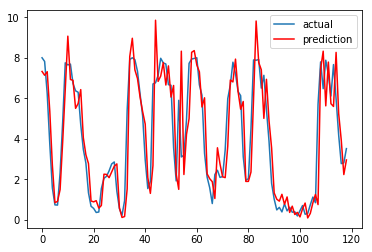

In [109]:
# X = series.values
# size = int(len(X) * 0.66)
# train, validate = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()
for t in range(len(validate)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = validate[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(validate, predictions)
r2 = metrics.r2_score(validate, predictions)
print('validate MSE: %.3f' % error)
print(f'validate r2: {r2}')
# plot
plt.plot(validate, label='actual')
plt.plot(predictions, color='red', label='prediction')
plt.legend()
plt.show()

##### ARIMA (with default parameters) performed well on the validation set.
MSE was 2.007 and r squared was about 0.73.

### Trying out SARIMAX
This model will be able to take seasonality into account.

In [110]:
# fitting model

series = df_agg[:split_point_train_validate]

# order parameters = (p, d, q)
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced
# q = size of the moving average window

model = SARIMAX(series, order=(5,1,0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      soil_moisture   No. Observations:                  119
Model:             SARIMAX(5, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -160.075
Date:                            Tue, 04 Jun 2019   AIC                            336.150
Time:                                    15:50:59   BIC                            357.457
Sample:                                03-31-1988   HQIC                           344.786
                                     - 01-31-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1858      0.099      1.881      0.060      -0.008       0.379
ar.L2         -0.2006      0.152   

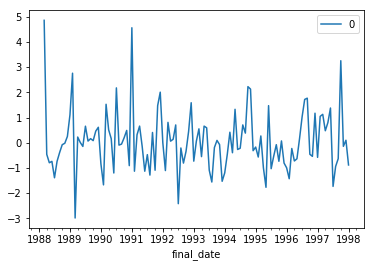

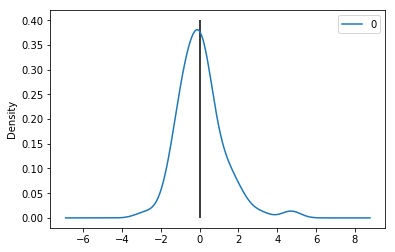

                0
count  119.000000
mean     0.056236
std      1.201155
min     -2.987001
25%     -0.733252
50%     -0.073178
75%      0.572039
max      4.858000


In [111]:
# plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.vlines(x=0, ymax=0.4, ymin=0)
plt.show()
print(residuals.describe())

predicted=7.883630, expected=8.000000
predicted=8.433119, expected=7.820000
predicted=8.119167, expected=6.237500
predicted=5.790938, expected=3.752000
predicted=3.044424, expected=1.582500
predicted=-0.010450, expected=0.747500
predicted=0.136923, expected=0.738000
predicted=0.915455, expected=2.327500
predicted=3.075365, expected=4.830000
predicted=6.178852, expected=7.750000
predicted=8.606883, expected=7.647500
predicted=7.740897, expected=7.688000
predicted=7.719955, expected=6.733333
predicted=6.631817, expected=6.370000
predicted=6.278721, expected=6.300000
predicted=5.925551, expected=4.706000
predicted=3.743131, expected=3.487500
predicted=2.007649, expected=2.807500
predicted=2.037585, expected=1.342000
predicted=1.325052, expected=0.680000
predicted=1.488987, expected=0.575000
predicted=2.018322, expected=0.374000
predicted=0.953396, expected=0.397500
predicted=1.787615, expected=1.554000
predicted=2.392599, expected=2.056667
predicted=2.403156, expected=2.156000
predicted=2

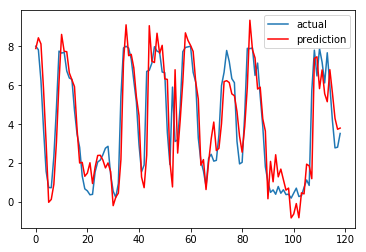

In [112]:
# X = series.values
# size = int(len(X) * 0.66)
# train, validate = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()
for t in range(len(validate)):
    model = SARIMAX(history, order=(5,1,0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = validate[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(validate, predictions)
r2 = metrics.r2_score(validate, predictions)
print('validate MSE: %.3f' % error)
print(f'validate r2: {r2}')
# plot
plt.plot(validate, label='actual')
plt.plot(predictions, color='red', label='prediction')
plt.legend()
plt.show()

##### SARIMAX (default parameters) performed even better than ARIMA.
The MSE was 1.820 and r squared was 0.76.

After seeing that SARIMAX performed well, I will look at the parameters and determine the one's that give the best performance.

### Finding the best parameters for SARIMAX.

In [185]:
p_to_try = [0, 1, 2]
d_to_try = [0, 1, 2]
q_to_try = [0, 1, 2]
P_to_try = [0, 1, 2]
D_to_try = [0, 1, 2]
Q_to_try = [0, 1, 2]
m_to_try = [12]

pdq_combos = [(1, 0, 0), (0, 1, 0), (1, 1, 0), (0, 1, 1), (5, 1, 0)]
PDQm_combos = [(1, 0, 0, 12), (0, 1, 0, 12), (1, 1, 0, 12), (0, 1, 1, 12)]

mse_dict = {}
# validate_mse_dict = {}
r2_dict = {}
# validate_r2 = {}

for combo in list(itertools.product(pdq_combos, PDQm_combos)):
#     if combo[0] > 0 and combo[2] > 0:
#         continue
#     if combo[3] > 0 and combo[5] > 0:
#         continue
    print(f'pdq: {combo[0]} PDQm: {combo[1]}')
    history = [x for x in train]
    predictions = list()
    for t in range(len(validate)):
        model = SARIMAX(history, order=(combo[0]), seasonal_order=(combo[1]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = validate[t]
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
        
    # print('Finished making predictions.')    
    error = metrics.mean_squared_error(validate, predictions)
    r2 = metrics.r2_score(validate, predictions)
    # print('Finished calculating error and R2.')
    # print('validate MSE: %.3f' % error)
    # print(f'validate r2: {r2}')

    mse_dict[f'pdq: {combo[0]} PDQm: {combo[1]}'] = error
    r2_dict[f'pdq: {combo[0]} PDQm: {combo[1]}'] = r2
    # print('Created dictionary entries.')
    # plt.plot(y_pred, 'b-', ytrain, 'r-')
    # plt.show()
    
print(f'The best hyperparameter combination by MSE was: {min(mse_dict, key=mse_dict.get)}')
print(f"The MSE for the validate set for that combo was: {mse_dict[f'{min(mse_dict, key=mse_dict.get)}']}")
print('\n')
print(f'The best hyperparameter combination by r2 was: {max(r2_dict, key=r2_dict.get)}')
print(f"The R2 for the validate set for that combo was: {r2_dict[f'{max(r2_dict, key=r2_dict.get)}']}")
# print('\n')
# print(f'The best window-step/hyperparameter combination by just the validation R2 was: {max(validate_r2, key=validate_r2.get)}')
# print(f"The R2 for the validate set for that combo was: {validate_r2[f'{max(validate_r2, key=validate_r2.get)}']}")
# print('\n')
# print(f'The best window-step/hyperparameter combination by average R2 was: {max(average_r2, key=average_r2.get)}')
# print(f"The average R2 for the validate set for that combo was: {average_r2[f'{max(average_r2, key=average_r2.get)}']}")

pdq: (1, 0, 0) PDQm: (1, 0, 0, 12)
pdq: (1, 0, 0) PDQm: (0, 1, 0, 12)
pdq: (1, 0, 0) PDQm: (1, 1, 0, 12)
pdq: (1, 0, 0) PDQm: (0, 1, 1, 12)
pdq: (0, 1, 0) PDQm: (1, 0, 0, 12)
pdq: (0, 1, 0) PDQm: (0, 1, 0, 12)


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq: (0, 1, 0) PDQm: (1, 1, 0, 12)
pdq: (0, 1, 0) PDQm: (0, 1, 1, 12)


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq: (1, 1, 0) PDQm: (1, 0, 0, 12)
pdq: (1, 1, 0) PDQm: (0, 1, 0, 12)
pdq: (1, 1, 0) PDQm: (1, 1, 0, 12)
pdq: (1, 1, 0) PDQm: (0, 1, 1, 12)
pdq: (0, 1, 1) PDQm: (1, 0, 0, 12)
pdq: (0, 1, 1) PDQm: (0, 1, 0, 12)


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq: (0, 1, 1) PDQm: (1, 1, 0, 12)
pdq: (0, 1, 1) PDQm: (0, 1, 1, 12)


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq: (5, 1, 0) PDQm: (1, 0, 0, 12)
pdq: (5, 1, 0) PDQm: (0, 1, 0, 12)
pdq: (5, 1, 0) PDQm: (1, 1, 0, 12)
pdq: (5, 1, 0) PDQm: (0, 1, 1, 12)
The best hyperparameter combination by MSE was: pdq: (1, 0, 0) PDQm: (0, 1, 1, 12)
The MSE for the validate set for that combo was: 1.784179572951891


The best hyperparameter combination by r2 was: pdq: (1, 0, 0) PDQm: (0, 1, 1, 12)
The R2 for the validate set for that combo was: 0.7714940432782467


##### The parameters that provided the best reults were pdq = (1, 0, 0) and PDQm = (0, 1, 1, 12).
This combination gave an MSE of 1.778 and an r squared of 0.768.

### Trying out the suggested parameters.

predicted=8.169877, expected=8.000000
predicted=8.060800, expected=7.820000
predicted=7.549343, expected=6.237500
predicted=5.713595, expected=3.752000
predicted=3.408296, expected=1.582500
predicted=0.151014, expected=0.747500
predicted=-0.423726, expected=0.738000
predicted=0.574509, expected=2.327500
predicted=2.912567, expected=4.830000
predicted=6.004021, expected=7.750000
predicted=8.329168, expected=7.647500
predicted=8.182856, expected=7.688000
predicted=7.870712, expected=6.733333
predicted=6.920927, expected=6.370000
predicted=5.922690, expected=6.300000
predicted=5.231642, expected=4.706000
predicted=3.794812, expected=3.487500
predicted=1.915961, expected=2.807500
predicted=1.653886, expected=1.342000
predicted=1.629894, expected=0.680000
predicted=2.169212, expected=0.575000
predicted=2.656431, expected=0.374000
predicted=1.712143, expected=0.397500
predicted=1.906954, expected=1.554000
predicted=2.335809, expected=2.056667
predicted=2.620005, expected=2.156000
predicted=2

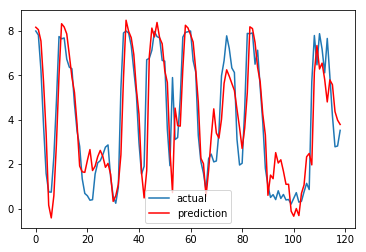

In [114]:
# X = series.values
# size = int(len(X) * 0.66)
# train, validate = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()
for t in range(len(validate)):
    model = SARIMAX(history, order=(1,0,0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = validate[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(validate, predictions)
r2 = metrics.r2_score(validate, predictions)
print('validate MSE: %.3f' % error)
print(f'validate r2: {r2}')
# plot
plt.plot(validate, label='actual')
plt.plot(predictions, color='red', label='prediction')
plt.legend()
plt.show()

### ARIMA again

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


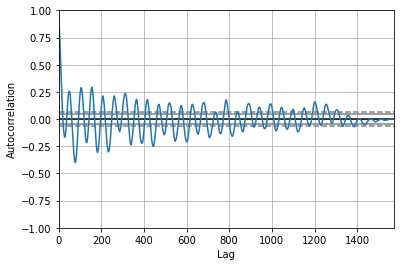

In [120]:
autocorrelation_plot(df.soil_moisture)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signa

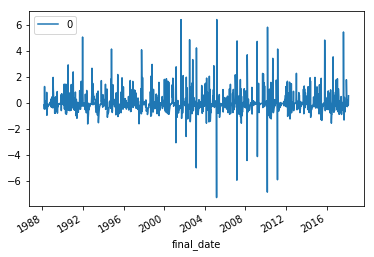

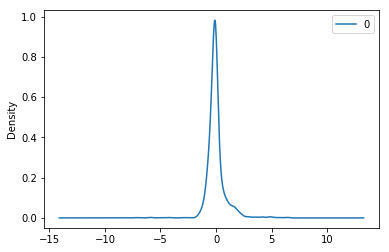

                 0
count  1570.000000
mean     -0.000033
std       0.885537
min      -7.261119
25%      -0.338395
50%      -0.083793
75%       0.101481
max       6.443886


In [122]:
# fit model
model = ARIMA(df.soil_moisture, order=(5,1,0))
model_fit = model.fit(disp=0)
# print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [123]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.soil_moisture   No. Observations:                 1570
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2036.396
Method:                       css-mle   S.D. of innovations              0.885
Date:                Tue, 04 Jun 2019   AIC                           4086.792
Time:                        16:03:59   BIC                           4124.304
Sample:                             1   HQIC                          4100.734
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0014      0.022      0.065      0.949      -0.042       0.045
ar.L1.D.soil_moisture    -0.1425      0.025     -5.653      0.000      -0.192      -0.093
ar.L2.D.

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

Test MSE: 1.506
Test R Squared: 0.762


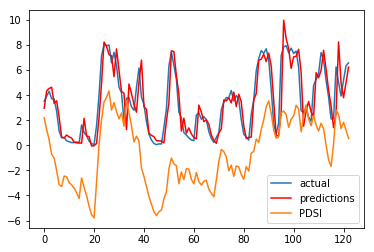

In [152]:
X = df_agg.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
r2 = metrics.r2_score(test, predictions)
print('Test R Squared: %.3f' % r2)
# plot
plt.plot(test, label='actual')
plt.plot(predictions, color='red', label='predictions')
plt.plot((np.array(df.pdsi.resample('M')
                   .agg('mean')[(len(X) - size):])), label='PDSI')
plt.legend()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

Validate MSE: 1.840
Validate R Squared: 0.764


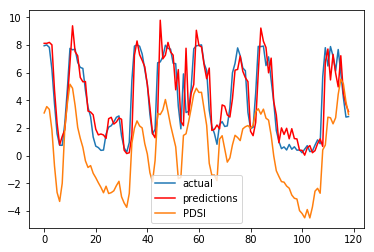

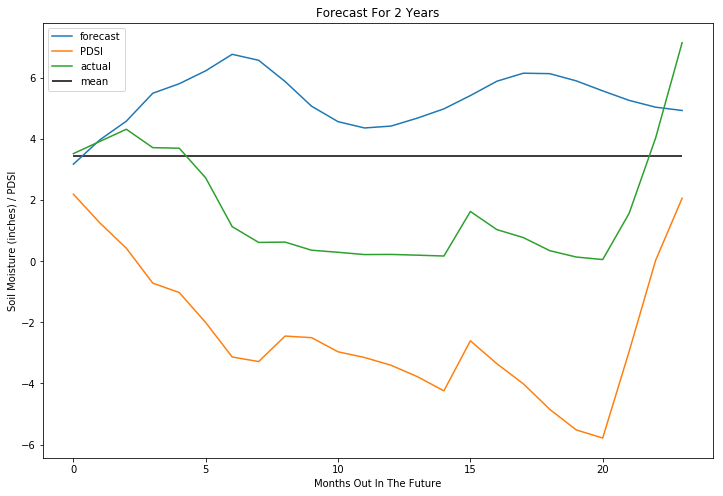

Drought predicted on: 02-2020
Drought predicted on: 03-2020
Drought predicted on: 04-2020
Drought predicted on: 05-2020
Drought predicted on: 06-2020
Drought predicted on: 01-2021
Drought predicted on: 02-2021
Drought predicted on: 03-2021
Drought predicted on: 04-2021
Drought predicted on: 05-2021
Drought predicted on: 06-2021


In [222]:
X = df_agg.values
first_size = int(len(X) * 0.33)
second_size = int(len(X) * 0.66)
train, validate, test = X[0:first_size], X[first_size:second_size], X[second_size:]
history = [x for x in train]
predictions = []
for t in range(len(validate)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = validate[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(validate, predictions)
print('Validate MSE: %.3f' % error)
r2 = metrics.r2_score(validate, predictions)
print('Validate R Squared: %.3f' % r2)
# plot
plt.plot(validate, label='actual')
plt.plot(predictions, color='red', label='predictions')
plt.plot((np.array(df.pdsi.resample('M')
                   .agg('mean')[first_size:second_size])), label='PDSI')

plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(model_fit.forecast(24)[0], label='forecast')
plt.plot((np.array(df.pdsi.resample('M')
                   .agg('mean')[second_size:(second_size + 24)])), label='PDSI')
plt.plot(test[:24], label='actual')
plt.hlines(test.mean(), xmax=23, xmin=0, label='mean')
plt.title('Forecast For 2 Years')
plt.xlabel('Months Out In The Future')
plt.ylabel('Soil Moisture (inches) / PDSI')
plt.legend()
plt.show()


for i, forecast in enumerate(model_fit.forecast(25)[0]):
    if i == 0:
        forecast_change = forecast - 0
    else:
        forecast_change = forecast - model_fit.forecast(25)[0][i-1]
    if forecast_change < 0:
        print(f'Drought predicted on: {datetime.datetime.strftime(datetime.datetime.today() + timedelta(days=(i+1) * 30.4), "%m-%Y")}')

In [293]:
precip = pd.read_csv('precipitation_totals.csv', index_col=0)
precip.head()

,DATE,Total
0,1893-01-01,0.11
1,1893-01-02,0.11
2,1893-01-03,0.11
3,1893-01-04,0.11
4,1893-01-05,0.11


In [294]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler(feature_range=(0, 1))
mmscaler.fit(precip[['Total']])
precip.Total = mmscaler.transform(precip[['Total']])

In [295]:
precip.DATE = pd.to_datetime(precip.DATE)

In [296]:
precip = precip.set_index('DATE')
precip.head()

,Total
DATE,
1893-01-01,0.013898
1893-01-02,0.013898
1893-01-03,0.013898
1893-01-04,0.013898
1893-01-05,0.013898


In [297]:
precip_agg = precip.Total.resample('M').agg('mean')['1997':'2017']
precip_agg.head()

DATE
1997-01-31    0.004334
1997-02-28    0.018786
1997-03-31    0.013952
1997-04-30    0.020524
1997-05-31    0.018530
Freq: M, Name: Total, dtype: float64

In [298]:
temp = pd.read_csv('temperature_data_cleaned_and_prepped.csv', index_col=0)
temp.head()

,max_temp,min_temp,avg_temp
date,,,
1895-01-01,24.96,4.48,14.72
1895-02-01,27.88,2.25,15.06
1895-03-01,35.51,11.12,23.31
1895-04-01,55.49,26.22,40.86
1895-05-01,57.78,31.86,44.82


In [299]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
mmscaler.fit(temp[['avg_temp']])
temp.avg_temp = mmscaler.transform(temp[['avg_temp']])

In [300]:
temp = temp.reset_index()
temp.date = pd.to_datetime(temp.date)
temp = temp.set_index('date')
temp.head()

,max_temp,min_temp,avg_temp
date,,,
1895-01-01,24.96,4.48,0.207013
1895-02-01,27.88,2.25,0.212219
1895-03-01,35.51,11.12,0.338539
1895-04-01,55.49,26.22,0.607258
1895-05-01,57.78,31.86,0.667892


In [301]:
temp_agg = temp.avg_temp.resample('M').agg('mean')['1997':'2017']

In [316]:
new_df = pd.read_csv('south_central_moisture_data_1988_2017.csv')
new_df.head()

,final_date,soil_moisture,pdsi
0,1988-03-01,4.79,0.0
1,1988-03-08,4.67,0.0
2,1988-03-15,4.24,0.0
3,1988-03-22,5.59,0.0
4,1988-03-29,5.00,0.0


In [317]:
new_df = new_df[['final_date', 'soil_moisture']]

mmscaler = MinMaxScaler(feature_range=(0, 1))
mmscaler.fit(new_df[['soil_moisture']])
new_df.soil_moisture = mmscaler.transform(new_df[['soil_moisture']])

new_df.head()

,final_date,soil_moisture
0,1988-03-01,0.598248
1,1988-03-08,0.583229
2,1988-03-15,0.529412
3,1988-03-22,0.698373
4,1988-03-29,0.624531


In [318]:
new_df.final_date = pd.to_datetime(new_df.final_date)
new_df = new_df.set_index('final_date')

In [319]:
new_df_agg = new_df.soil_moisture.resample('M').agg('mean')

In [320]:
new_df_agg = new_df_agg['1997':'2017']

In [303]:
reservoir = pd.read_csv('reservoir_data/san-antonio_reservoir_data.csv')
reservoir.head()

,date,reservoir_storage,conservation_storage,percent_full,conservation_capacity
0,8/9/97,304449,254823,100.0,254823
1,8/10/97,304449,254823,100.0,254823
2,8/11/97,304449,254823,100.0,254823
3,8/12/97,304449,254823,100.0,254823
4,8/13/97,303783,254823,100.0,254823


In [304]:
reservoir.date = pd.to_datetime(reservoir.date)

In [305]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
mmscaler.fit(reservoir[['reservoir_storage']])
reservoir.reservoir_storage = mmscaler.transform(reservoir[['reservoir_storage']])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [306]:
reservoir = reservoir.set_index('date')
reservoir.head()

,reservoir_storage,conservation_storage,percent_full,conservation_capacity
date,,,,
1997-08-09,1.000000,254823,100.0,254823
1997-08-10,1.000000,254823,100.0,254823
1997-08-11,1.000000,254823,100.0,254823
1997-08-12,1.000000,254823,100.0,254823
1997-08-13,0.997761,254823,100.0,254823


In [307]:
reservoir_agg = reservoir.reservoir_storage.resample('M').agg('mean')['1997':'2017']

In [323]:
reservoir_agg.head()

date
1997-08-31    0.990936
1997-09-30    0.953454
1997-10-31    0.926251
1997-11-30    0.909837
1997-12-31    0.901889
Freq: M, Name: reservoir_storage, dtype: float64

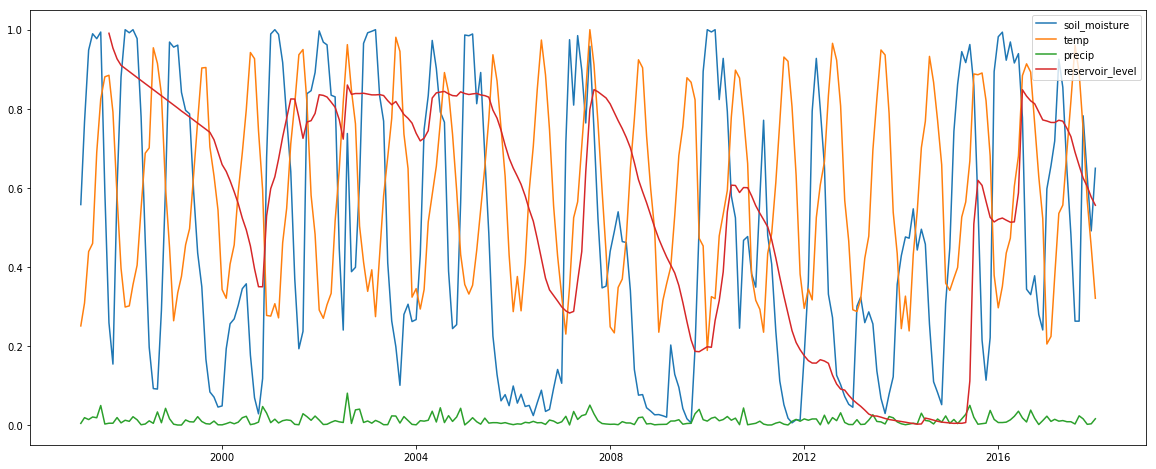

In [322]:
plt.figure(figsize=(20, 8))
plt.plot(new_df_agg, label='soil_moisture')
plt.plot(temp_agg, label='temp')
plt.plot(precip_agg, label='precip')
plt.plot(reservoir_agg, label='reservoir_level')
plt.legend()

# Prophet Model

In [351]:
new_df_agg = new_df_agg['1997-08':]

In [359]:
sr = new_df_agg.reset_index().join(reservoir_agg.reset_index()).drop(columns='date')
sr.head()

,final_date,soil_moisture,reservoir_storage
0,1997-08-31,0.258573,0.990936
1,1997-09-30,0.154255,0.953454
2,1997-10-31,0.599186,0.926251
3,1997-11-30,0.880601,0.909837
4,1997-12-31,1.000000,0.901889


In [361]:
prophet_df = sr[['final_date', 'reservoir_storage']]
prophet_df.columns = ['ds', 'y']
prophet_df.head()

,ds,y
0,1997-08-31,0.990936
1,1997-09-30,0.953454
2,1997-10-31,0.926251
3,1997-11-30,0.909837
4,1997-12-31,0.901889


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


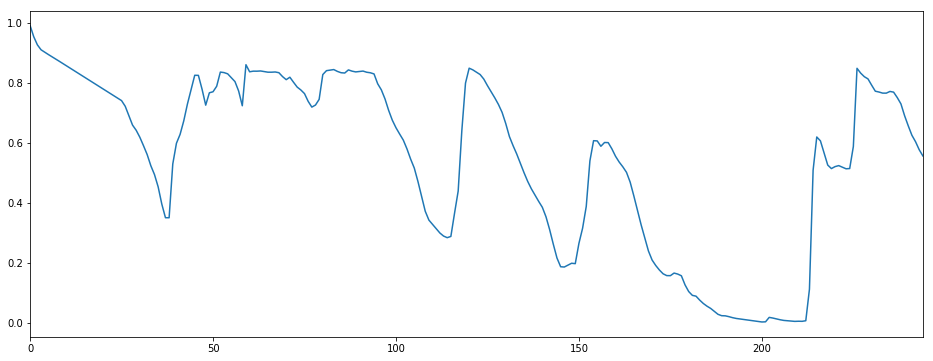

In [362]:
plt.figure(figsize=(16,6))
sns.tsplot(prophet_df.y)

##### Setting the cap and the floor

In [363]:
pd.read_csv('reservoir_data/san-antonio_reservoir_data.csv').reservoir_storage.max()

304449

In [364]:
pd.read_csv('reservoir_data/san-antonio_reservoir_data.csv').reservoir_storage.min()

6934

In [382]:
prophet_df['cap'] = 1
prophet_df['floor'] = 0
prophet_df['soil_moisture'] = sr.soil_moisture

##### Fitting the Prophet model

In [383]:
m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.add_regressor('soil_moisture')
m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


##### Creating a "future" dataframe.

In [393]:
future = m.make_future_dataframe(periods=90)
future['soil_moisture'] = sr.soil_moisture
future['cap'] = 1
future['floor'] = 0
print(future.head())
print(future.tail())
print(prophet_df.tail())

future.soil_moisture = future.soil_moisture.fillna(sr.soil_moisture.mean())

          ds  soil_moisture  cap  floor
0 1997-08-31       0.258573    1      0
1 1997-09-30       0.154255    1      0
2 1997-10-31       0.599186    1      0
3 1997-11-30       0.880601    1      0
4 1997-12-31       1.000000    1      0
            ds  soil_moisture  cap  floor
330 2018-03-27            NaN    1      0
331 2018-03-28            NaN    1      0
332 2018-03-29            NaN    1      0
333 2018-03-30            NaN    1      0
334 2018-03-31            NaN    1      0
            ds         y  cap  floor  soil_moisture
240 2017-08-31  0.656415    1      0       0.262829
241 2017-09-30  0.624852    1      0       0.782228
242 2017-10-31  0.603278    1      0       0.627972
243 2017-11-30  0.576547    1      0       0.491114
244 2017-12-31  0.555959    1      0       0.649562


##### Predicitions

In [394]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
330,2018-03-27,0.145267,-0.170260,0.439471
331,2018-03-28,0.147122,-0.145353,0.421811
332,2018-03-29,0.151413,-0.121036,0.440431
333,2018-03-30,0.157868,-0.146824,0.442940
334,2018-03-31,0.166162,-0.131745,0.459979


##### Plotting

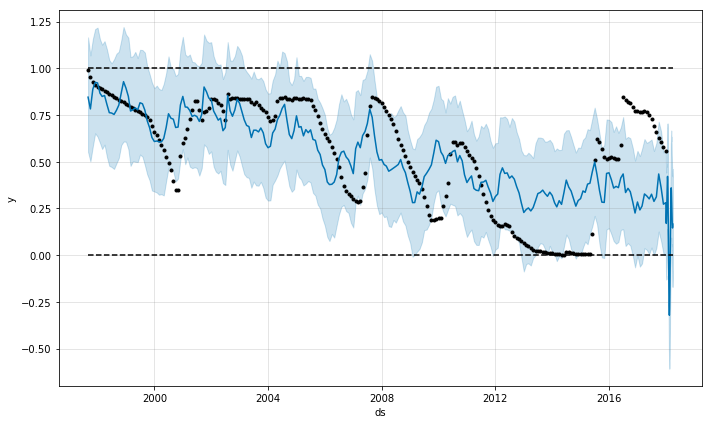

In [395]:
fig1 = m.plot(forecast)

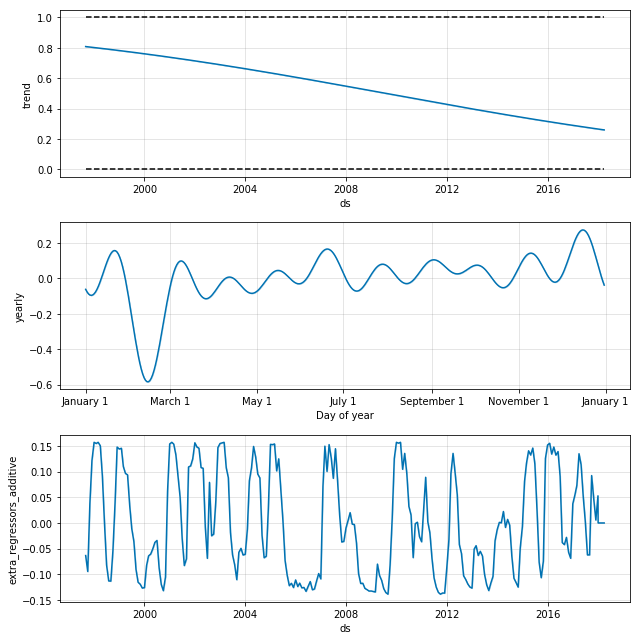

In [396]:
fig2 = m.plot_components(forecast)